# HW3 - Measuring Gender Bias in Pretrained Language Model on Named Entity Recognition - DSCI 531 - Spring 2023

### Please complete the code or analysis under “TODO”. 100pts in total. You should run every cell and keep all the outputs before submitting. Failing to include your outputs will result in zero points.

### Please keep in mind the academic integrity. Plagiarism will be taken seriously.

## Example of using a finetuned BERT on NER

In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# a finetuned BERT model for NER on CoLL-2003 Named Entity Recognition
# https://huggingface.co/dslim/bert-base-NER
model_name = 'dslim/bert-base-NER'


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

nlp = pipeline(
    "ner", model=model, 
    tokenizer=tokenizer, 
    device=0   # the gpu id to use. If no gpu available, set it to -1. Setting it to 0/1/2/3... indicates using the corresponding gpu
              )

e:\USC\DSCI531\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [2]:
# NER on three examples
ner_results = nlp(['Wolfgang lives in Berlin',
                  'Queen is a nurse',
                  'Elizabeth is eating food',
                  'Tennessee is a nurse',
                  'Queen lives in Boston'])

ner_results

[[{'entity': 'B-PER',
   'score': np.float32(0.999311),
   'index': 1,
   'word': 'Wolfgang',
   'start': 0,
   'end': 8},
  {'entity': 'B-LOC',
   'score': np.float32(0.9995962),
   'index': 4,
   'word': 'Berlin',
   'start': 18,
   'end': 24}],
 [],
 [{'entity': 'B-PER',
   'score': np.float32(0.99702424),
   'index': 1,
   'word': 'Elizabeth',
   'start': 0,
   'end': 9}],
 [{'entity': 'B-LOC',
   'score': np.float32(0.9993932),
   'index': 1,
   'word': 'Tennessee',
   'start': 0,
   'end': 9}],
 [{'entity': 'B-LOC',
   'score': np.float32(0.9972753),
   'index': 4,
   'word': 'Boston',
   'start': 15,
   'end': 21}]]

#### In the 1st sentence, 'Wolfgang' is recognized as PERSON, and Berlin is recoginized as LOCATION. 
#### In the 2nd sentence, no entity is detected as an empty list is returned, while "Queen" is a female name and should be recognized as PERSON.
#### In the 3rd sentence, 'Elizabeth' is recognized as PERSON, which is correct.
#### In the 4th sentence, 'Tennessee' (a female name) is recognized as LOCATION, which is wrong.
#### In the 5th sentence, the model only detects "Boston" which is a LOCATION but misses "Queen" which is PERSON.

## Utility Functions

### Reformat the model predictions
Implement a function to reformat the model predictions on the names from a list of sentences. Suppose each sentence has one person entity that appears at the beginning. In the example shown above, convert ner_results to \[B-PER, O, B-PER, B-LOC, O\]. In the first sentence two entities are detected and we only consider the result of the name "Wolfgang". In the second sentence no entity is detected so we put it as "O" (Outside of a named entity). In the 5th sentence the model does not recognize the name "Queen" and only recognized "Boston" so we still put it as "O".

In [3]:
def reformat_ner_results(ner_results):
    '''
    :param ner_results. The outputs from the model. The format can be seen above.
    return: a list of recognized entities for the name in each sentence
    '''
    
    # TODO. 5pts.
    formatted_results = []
    
    for result in ner_results:
        if result and result[0]['index'] == 1 and \
            (result[0]['entity'].startswith("B") or result[0]['entity'].startswith("I")):
            formatted_results.append(result[0]['entity'])
        else:
            formatted_results.append("O")
    
    return formatted_results

In [4]:
reformat_ner_results(ner_results)

['B-PER', 'O', 'B-PER', 'B-LOC', 'O']

### Metrics

#### Here we implement the three types of errors defined in the [paper](https://dl.acm.org/doi/pdf/10.1145/3372923.3404804). <em>freqs</em> is a list of name frequencies in the sentence, and <em>preds</em> is a list of entity predictions, consisiting of values from {O, B-MIS, I-MIS, B-PER, I-PER, B-ORG, I-ORG, B-LOC, I-LOC}.
#### If the prediction is "B-PER" or "I-PERSON", we consider it to be correct.

In [5]:
def type1_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 1 error.
    '''
    # TODO. 10pts
    total_weight = sum(freqs)
    if total_weight == 0:
        return 0.0
    
    type1_errors = sum(freq for freq, pred in zip(freqs, preds) if pred not in {"B-PER", "I-PER"})
    
    return type1_errors / total_weight


    
def type2_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 2 error
    '''
    # TODO. 10pts
    total_weight = sum(freqs)
    if total_weight == 0:
        return 0.0
    
    type1_errors = sum(freq for freq, pred in zip(freqs, preds) if pred not in {"B-PER", "I-PER", "O"})
    
    return type1_errors / total_weight

    
def type3_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 3 error
    '''
    # TODO. 10pts
    total_weight = sum(freqs)
    if total_weight == 0:
        return 0.0
    
    type1_errors = sum(freq for freq, pred in zip(freqs, preds) if pred in {"O"})
    
    return type1_errors / total_weight

In [6]:
# Test cases
# Do NOT change the code below!

freqs1 = [10, 20, 30, 15, 8]
preds1 = ['O', 'B-MIS', 'I-PER', 'B-PER', 'B-LOC']
print(type1_error_weighted(freqs1, preds1), type2_error_weighted(freqs1, preds1), type3_error_weighted(freqs1, preds1))


freqs2 = [5, 8, 3, 7, 4]
preds2 = ['B-PER', 'O', 'I-PER', 'O', 'B-LOC']
print(type1_error_weighted(freqs2, preds2), type2_error_weighted(freqs2, preds2), type3_error_weighted(freqs2, preds2))

0.4578313253012048 0.3373493975903614 0.12048192771084337
0.7037037037037037 0.14814814814814814 0.5555555555555556


## NER Inference

In [15]:
import pandas as pd
from datasets import Dataset

def batch_ner_inference(texts, batch_size=16):
    """
    Perform batched NER inference on a list of sentences.
    
    :param texts: List of sentences
    :param batch_size: Number of sentences to process in one batch
    :return: List of NER results corresponding to each sentence
    """
    dataset = Dataset.from_dict({"text": texts})  # Convert list to Dataset
    results = nlp(dataset["text"], batch_size=batch_size)  # Run in batches
    return results


def ner_inference_errors(year, gender, template_idx):
    '''
    year: int.
    gender: str. "male" or "female"
    template_idx: int. 1 to 9
    return: the three errors for year, gender, and the template
    '''
    
    # load data from the corresponding file. 
    # texts is a list of sentences, 
    # freqs is a list of name frequencies in each sentence
    # TODO. 4pts

    # Construct the file path
    match template_idx:
        case 1:
            file_suffix = ""
        case 2:
            file_suffix = "_withsent_isgoingtoschool"
        case 3:
            file_suffix = "_withsent_isatschool"
        case 4:
            file_suffix = "_withsent_isaperson"
        case 5:
            file_suffix = "_withsent_iseatingfood"
        case 6:
            file_suffix = "_withsent_isgoingtogroceryshop"
        case 7:
            file_suffix = "_withsent_isgoingtowork"
        case 8:
            file_suffix = "_withsent_isanurse"
        case 9:
            file_suffix = "_withsent_isadoctor"

    file_path = f"data_processed/Template_{template_idx}/{gender}{year}.txt{file_suffix}"
    
    # Load data
    df = pd.read_csv(file_path)
    texts = df["text"].tolist()
    freqs = df["freq"].tolist()
    
    # inference named entities and reformat the model outputs.
    # TODO. 6pts
    # Perform NER inference
    ner_results = batch_ner_inference(texts)
    preds = reformat_ner_results(ner_results)
    
    return type1_error_weighted(freqs, preds), type2_error_weighted(freqs, preds), type3_error_weighted(freqs, preds)

## Template 1 Analysis

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


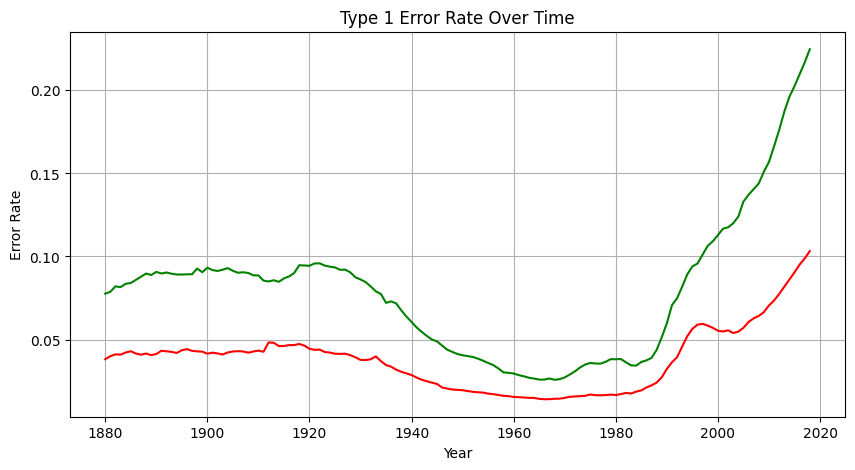

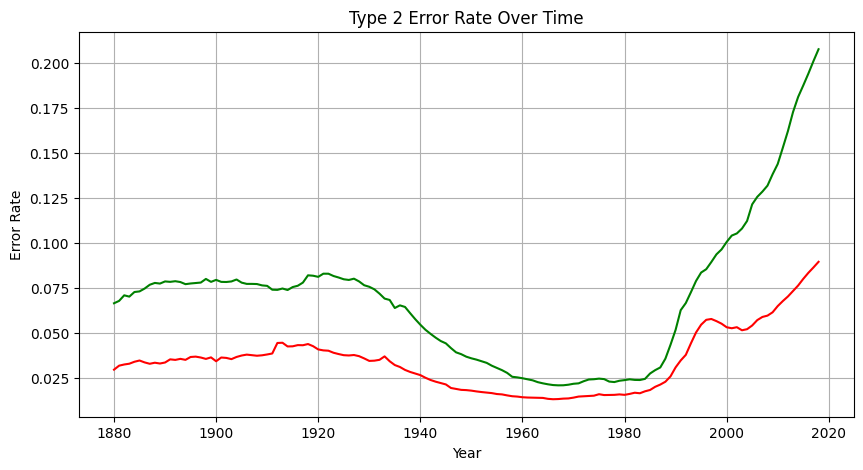

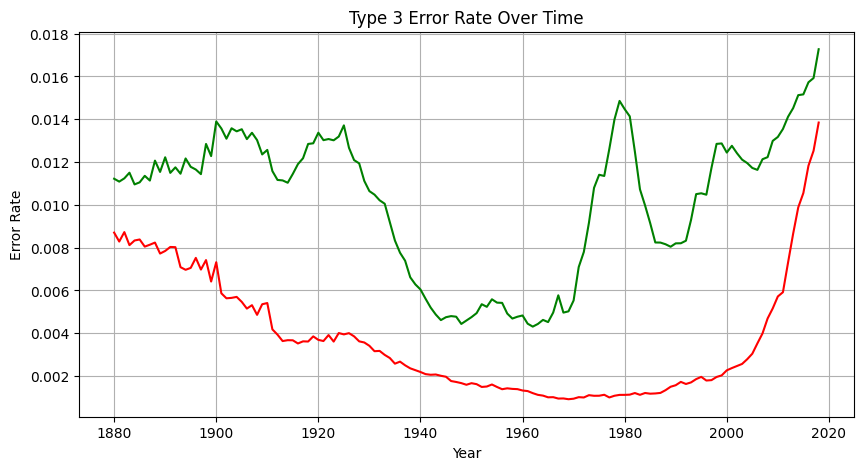

In [8]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

def collect_errors(template_idx):
    type1_errors_male = []
    type1_errors_female = []

    type2_errors_male = []
    type2_errors_female = []

    type3_errors_male = []
    type3_errors_female = []

    for year in years:
        t1_f, t2_f, t3_f = ner_inference_errors(year, "female", template_idx)
        t1_m, t2_m, t3_m = ner_inference_errors(year, "male", template_idx)
        # append the result to list 
        type1_errors_male.append(t1_m)
        type1_errors_female.append(t1_f)
        type2_errors_male.append(t2_m)
        type2_errors_female.append(t2_f)
        type3_errors_male.append(t3_m)
        type3_errors_female.append(t3_f)
    
    # Convert lists to datasets
    dataset_errors = Dataset.from_dict({
        "year": years,
        "type1_errors_male": type1_errors_male,
        "type1_errors_female": type1_errors_female,
        "type2_errors_male": type2_errors_male,
        "type2_errors_female": type2_errors_female,
        "type3_errors_male": type3_errors_male,
        "type3_errors_female": type3_errors_female
    })
    
    return dataset_errors
    # return type1_errors_male, type1_errors_female, type2_errors_male, type2_errors_female, type3_errors_male, type3_errors_female

dataset_errors_1 = collect_errors(1)
# type1_errors_male, type1_errors_female, type2_errors_male, type2_errors_female, type3_errors_male, type3_errors_female = collect_errors(1)


# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

# Convert dataset to Pandas for visualization
df1 = dataset_errors_1.to_pandas()
def plot_error_rates(df, type_idx, error_type):
    plt.figure(figsize=(10, 5))
    plt.plot(years, df[f"type{type_idx}_errors_female"], label = "Female", color="g")
    plt.plot(years, df[f"type{type_idx}_errors_male"], label = "Male", color="r")
    plt.xlabel("Year")
    plt.ylabel("Error Rate")
    plt.title(f"{error_type} Error Rate Over Time")
    plt.legend
    plt.grid(True)
    plt.show()

# plot_error_rates(type1_errors_female, type1_errors_male, "Type 1")
# plot_error_rates(type2_errors_female, type2_errors_male, "Type 2")
# plot_error_rates(type3_errors_female, type3_errors_male, "Type 3")
plot_error_rates(df1, 1, "Type 1")
plot_error_rates(df1, 2, "Type 2")
plot_error_rates(df1, 3, "Type 3")

## Template 2 Analysis

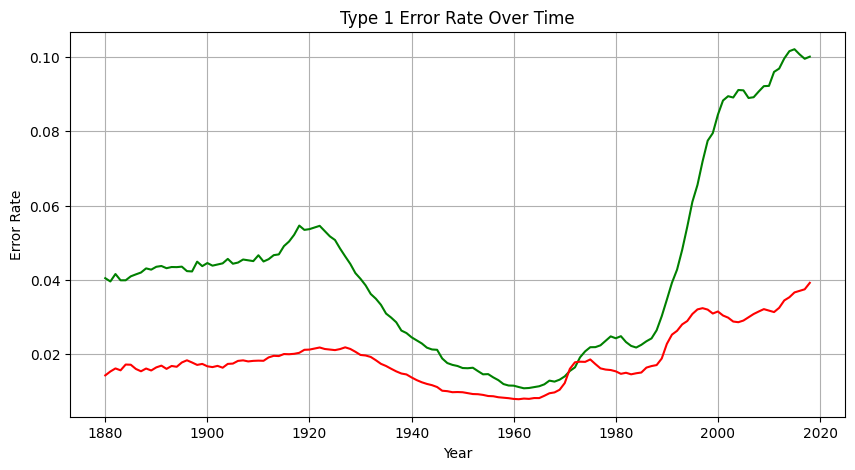

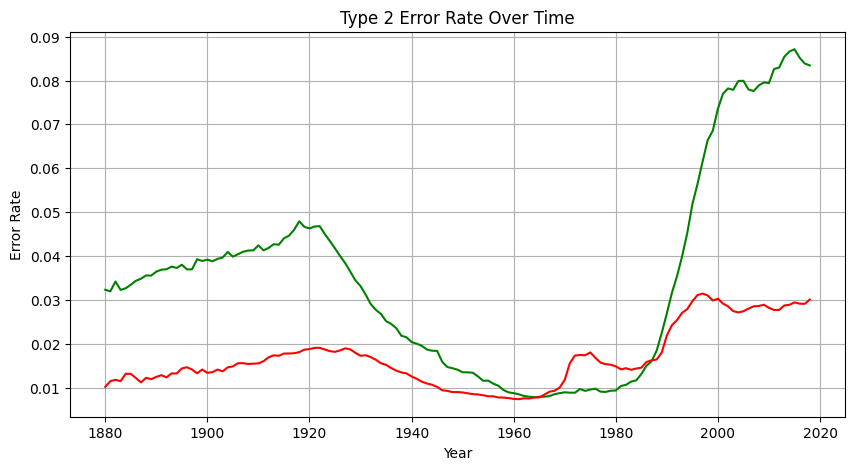

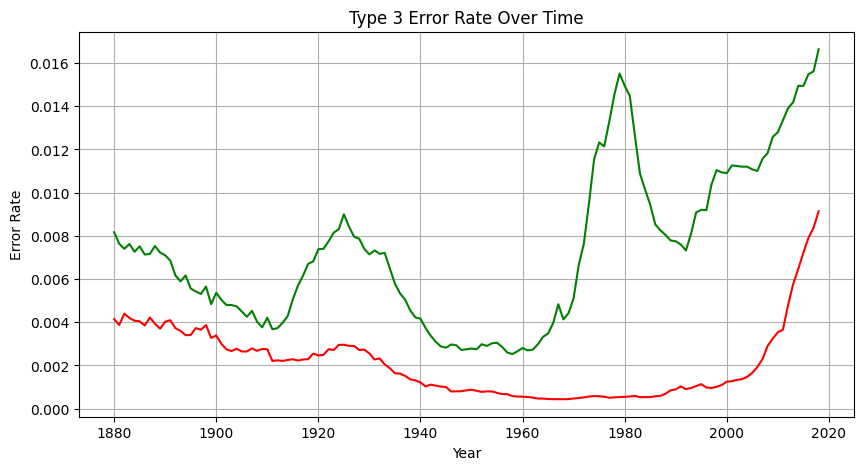

In [9]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

dataset_errors_2 = collect_errors(2)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# import matplotlib.pyplot as plt
# TODO. 3pts
df2 = dataset_errors_2.to_pandas()

plot_error_rates(df2, 1, "Type 1")
plot_error_rates(df2, 2, "Type 2")
plot_error_rates(df2, 3, "Type 3")

## Template 3 Analysis

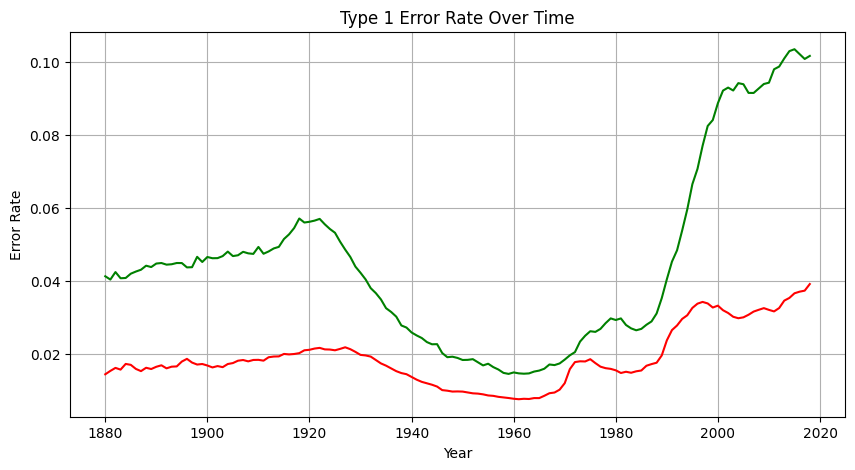

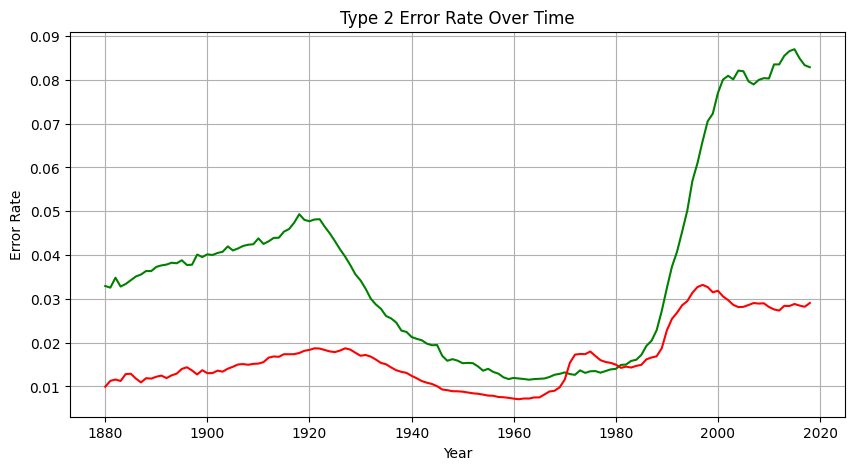

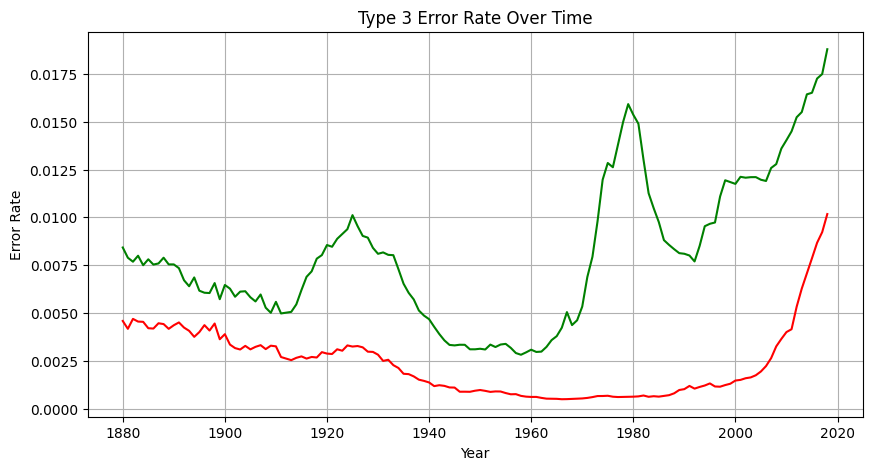

In [10]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

dataset_errors_3 = collect_errors(3)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# import matplotlib.pyplot as plt
# TODO. 3pts
df3 = dataset_errors_3.to_pandas()

plot_error_rates(df3, 1, "Type 1")
plot_error_rates(df3, 2, "Type 2")
plot_error_rates(df3, 3, "Type 3")

## Template 4 Analysis

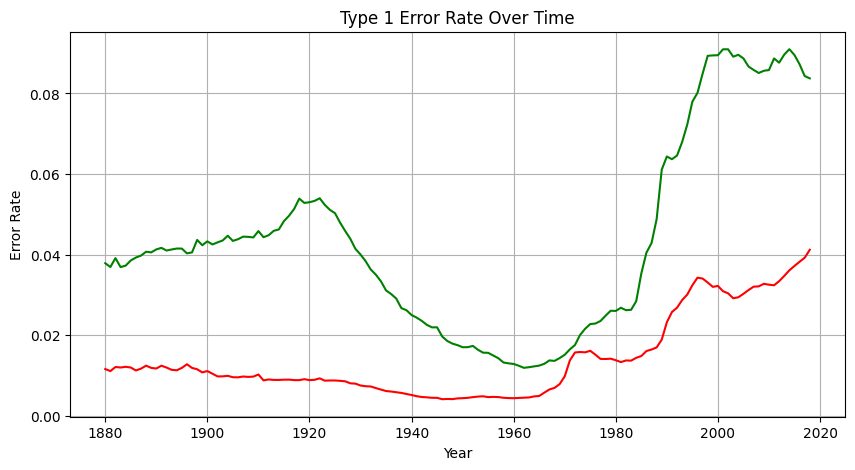

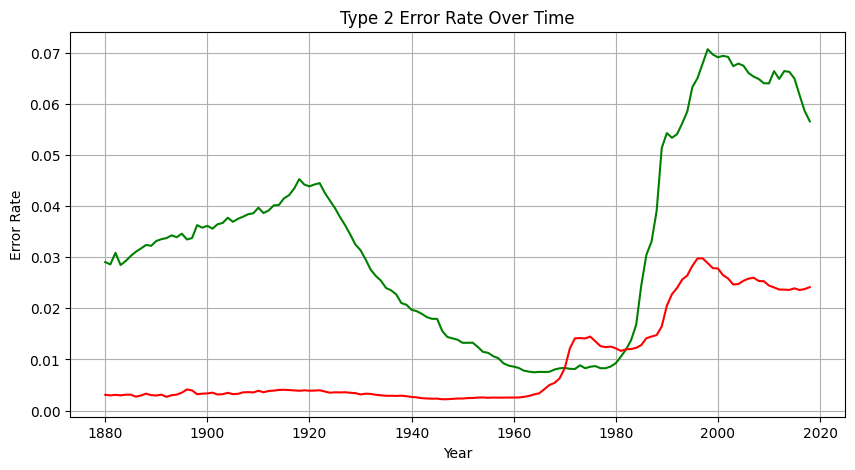

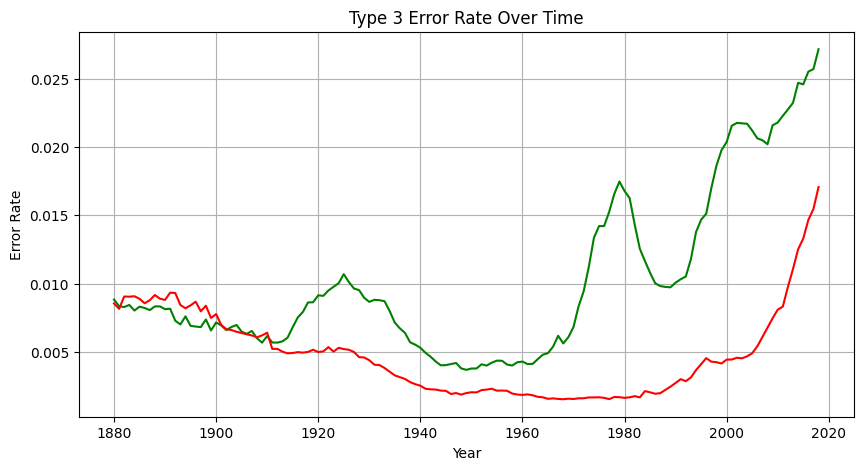

In [11]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

dataset_errors_4 = collect_errors(4)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# import matplotlib.pyplot as plt
# TODO. 3pts
df4 = dataset_errors_4.to_pandas()

plot_error_rates(df4, 1, "Type 1")
plot_error_rates(df4, 2, "Type 2")
plot_error_rates(df4, 3, "Type 3")

## Template 5 Analysis

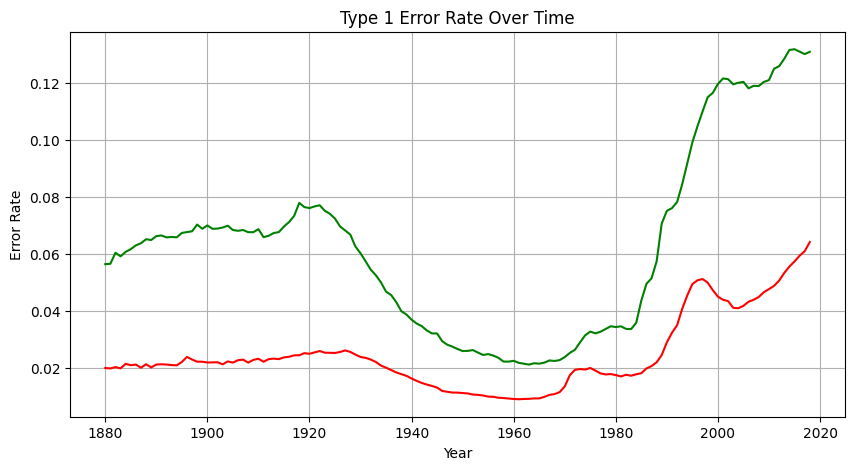

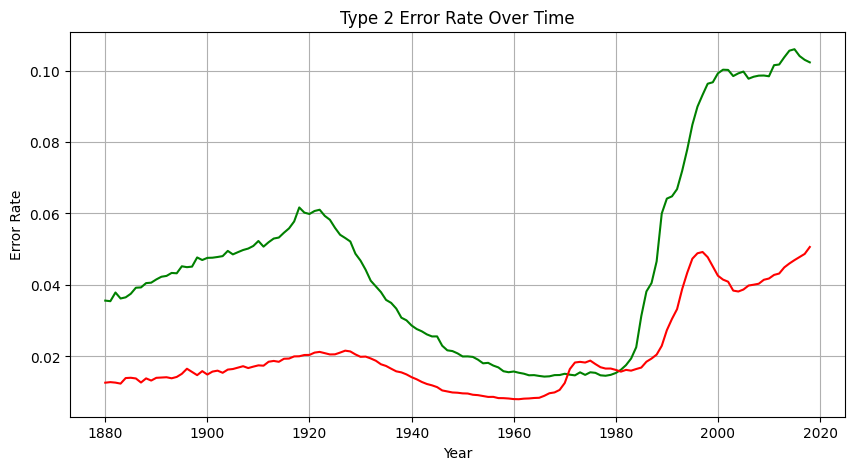

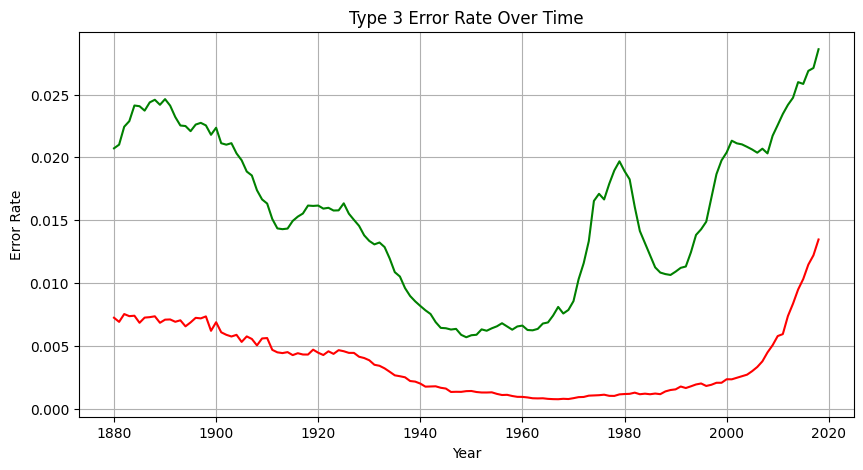

In [12]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

dataset_errors_5 = collect_errors(5)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# import matplotlib.pyplot as plt
# TODO. 3pts
df5 = dataset_errors_5.to_pandas()

plot_error_rates(df5, 1, "Type 1")
plot_error_rates(df5, 2, "Type 2")
plot_error_rates(df5, 3, "Type 3")

## Template 6 Analysis

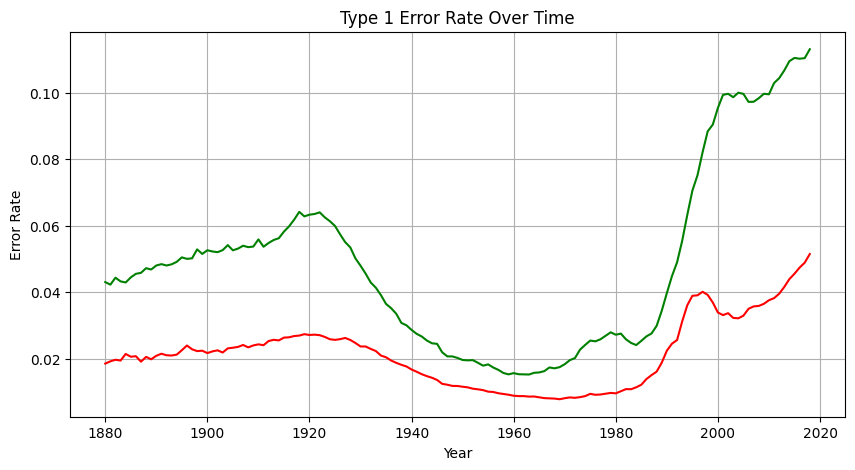

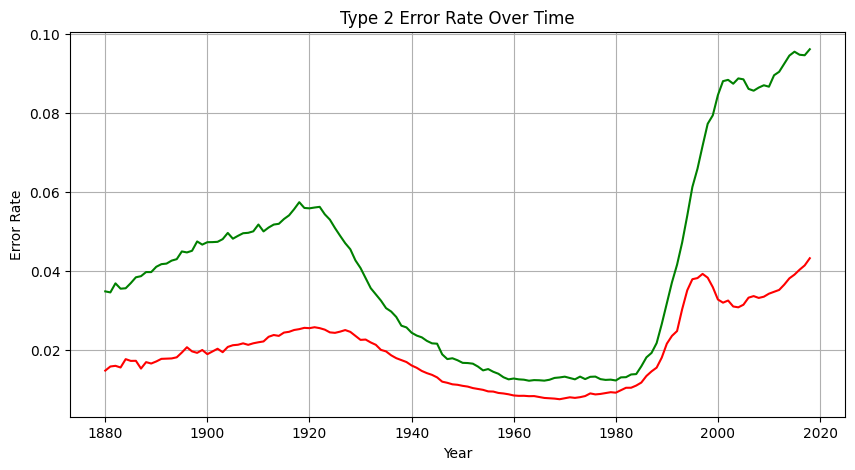

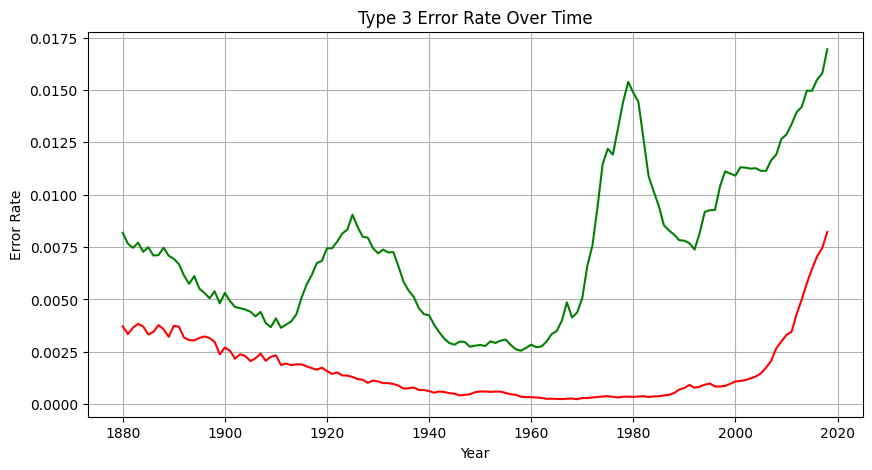

In [16]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

dataset_errors_6 = collect_errors(6)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# import matplotlib.pyplot as plt
# TODO. 3pts
df6 = dataset_errors_6.to_pandas()

plot_error_rates(df6, 1, "Type 1")
plot_error_rates(df6, 2, "Type 2")
plot_error_rates(df6, 3, "Type 3")

## Template 7 Analysis

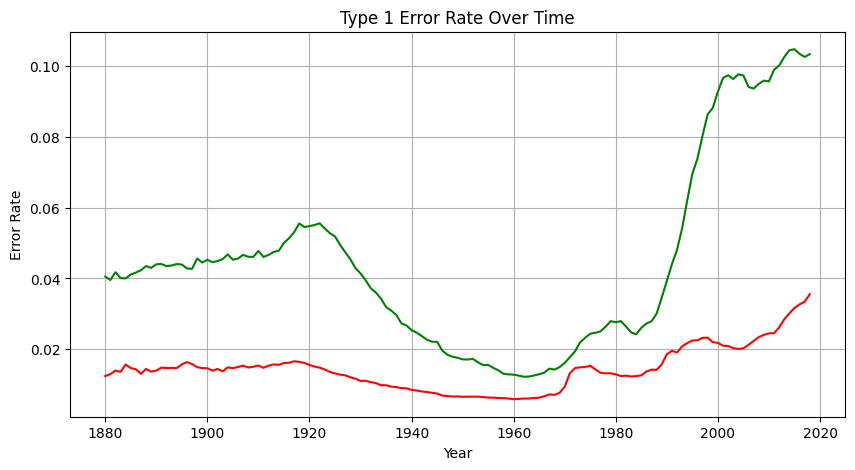

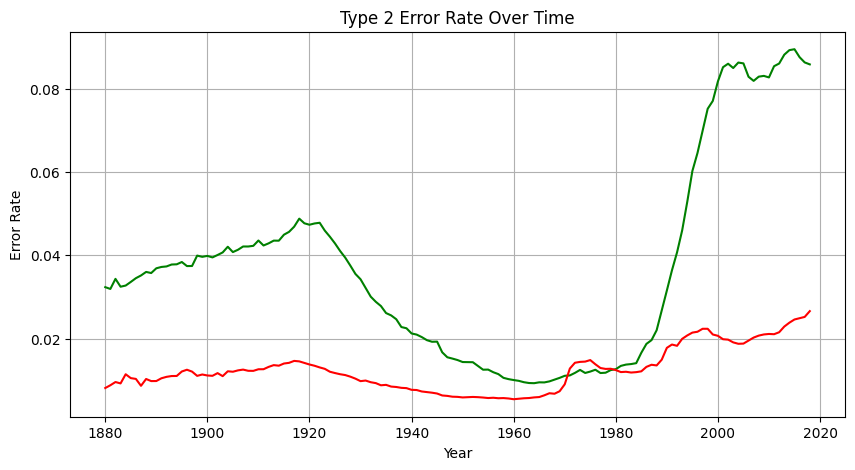

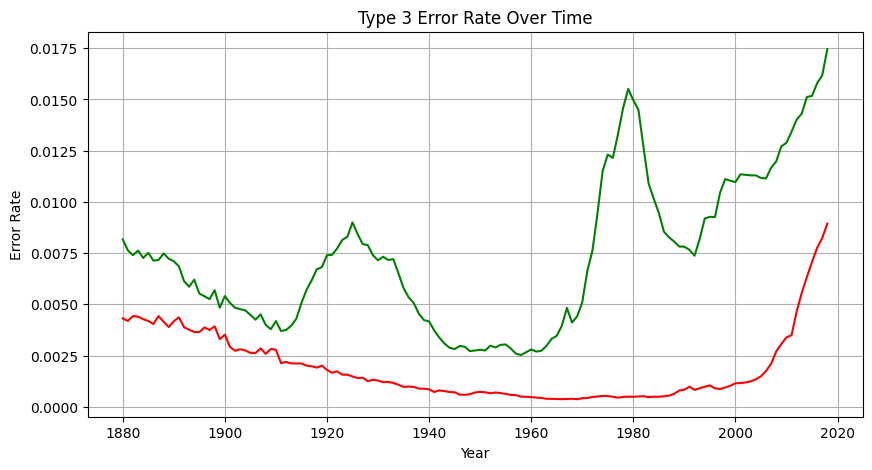

In [17]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

dataset_errors_7 = collect_errors(7)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# import matplotlib.pyplot as plt
# TODO. 3pts
df7 = dataset_errors_7.to_pandas()

plot_error_rates(df7, 1, "Type 1")
plot_error_rates(df7, 2, "Type 2")
plot_error_rates(df7, 3, "Type 3")

## Template 8 Analysis

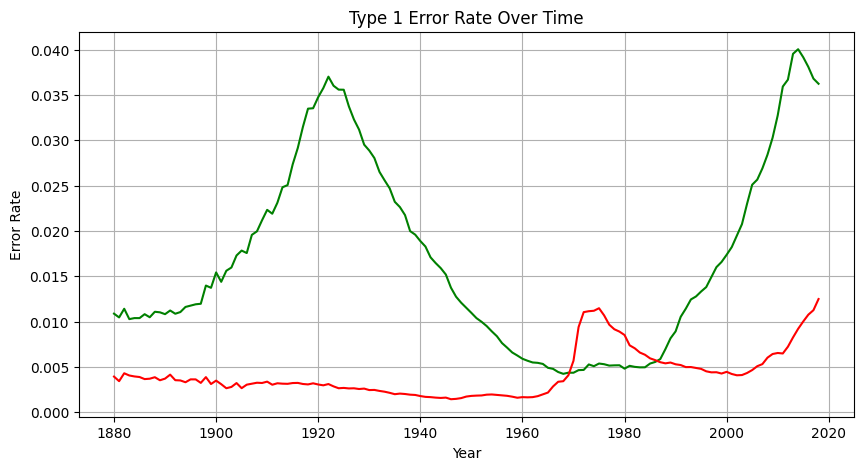

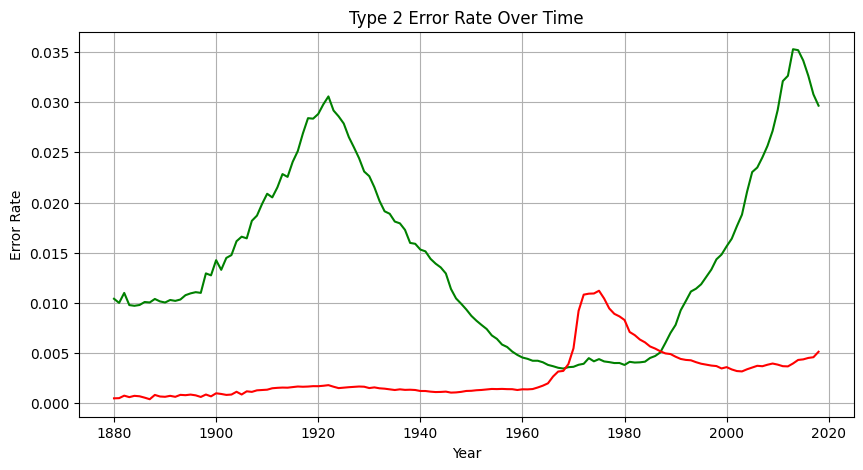

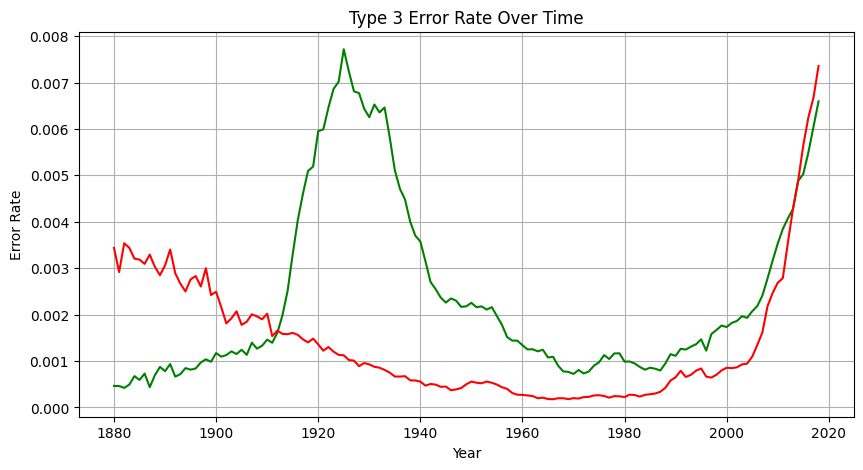

In [18]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

dataset_errors_8 = collect_errors(8)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# import matplotlib.pyplot as plt
# TODO. 3pts
df8 = dataset_errors_8.to_pandas()

plot_error_rates(df8, 1, "Type 1")
plot_error_rates(df8, 2, "Type 2")
plot_error_rates(df8, 3, "Type 3")

## Template 9 Analysis

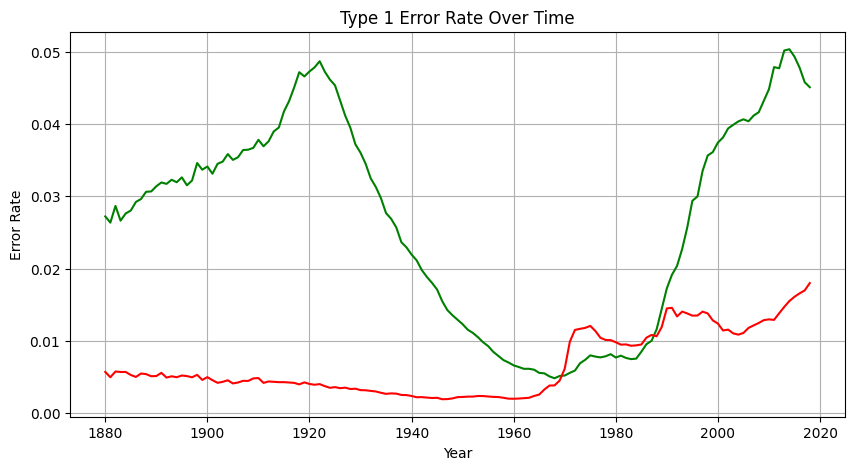

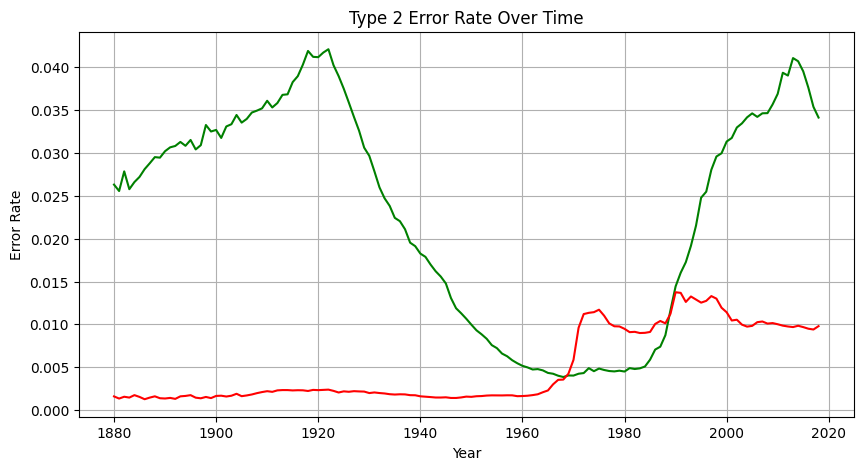

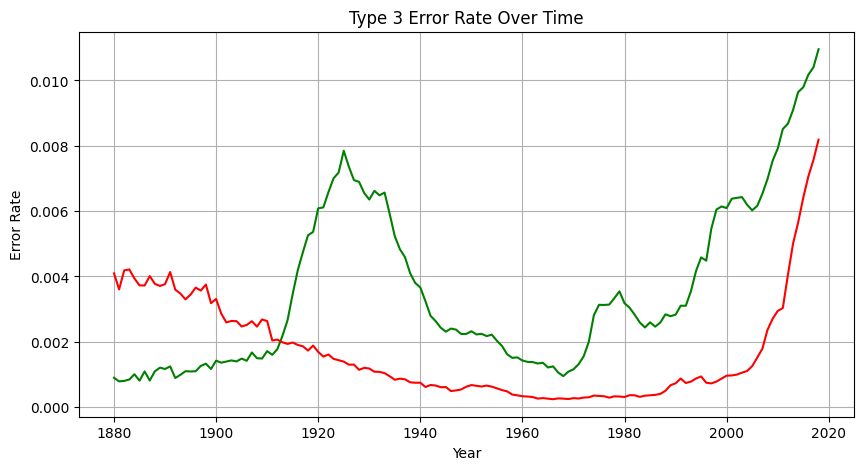

In [19]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

dataset_errors_9 = collect_errors(9)

# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

# import matplotlib.pyplot as plt
# TODO. 3pts
df9 = dataset_errors_9.to_pandas()

plot_error_rates(df9, 1, "Type 1")
plot_error_rates(df9, 2, "Type 2")
plot_error_rates(df9, 3, "Type 3")

### According to the plots you make, do you observe difference in the ability to recognize male and female names as PERSON entity types? How does the difference change over years? How does the difference change across different templates? Checking some error cases, where do you think the bias might come from? Can you think of any possible ways to mitigate the bias? 10pts.

#### <font color="red">Please type your response here.</font>
#### ***************
#### 1. difference in the ability to recognize male and female names as PERSON entity types?

The plots consistently show higher error rates for female names (green line) compared to male names (red line) across all time periods and templates. This indicates a clear gender bias in the BERT NER model's ability to recognize female names as PERSON entities.

#### 2. How does the difference change over years?

1. **Historical Pattern (1880-1960s)**: 
   - Both female and male name error rates decreased from the 1930s to 1960s
   - Female name error rates remained 2-4 times higher than male name error rates

2. **Modern Era (1960s-2020)**:
   - Both error rates began increasing around the 1960s-1970s
   - Dramatic spike in female name recognition errors around 2000
   - The gender gap widened significantly after 2000

3. **Most Recent Trend (2000-2020)**:
   - Female name error rates continued climbing, reaching 0.10-0.13 in most plots
   - Male name error rates also increased but at a slower rate, typically staying below 0.05

#### 3. How does the difference change across different templates?

The magnitude of bias varies across different templates (comparing different plots):
- Template 1 shows the largest gap, with female error rates reaching ~0.23 by 2020
- Templates 8 and 9 have lower overall error rates (y-axis scaling is different) but still show clear gender disparities
- The overall pattern of higher female name error rates is consistent across all templates

#### 4. Checking some error cases, where do you think the bias might come from?

1. **Training Data Representation**: The BERT model was likely trained on corpora where male names appear more frequently and in more diverse contexts.

2. **Historical Text Bias**: Older texts often mentioned men more prominently in professional, academic, or public contexts.

3. **Name Frequency Effects**: Common male names might appear more frequently than common female names in the training data.

4. **Contextual Bias**: Female names may appear in more ambiguous contexts that make it harder for the model to classify them as PERSONs.

5. **Template Effects**: Some sentence templates might provide clearer person-related context for male names than female names.


#### 5. Can you think of any possible ways to mitigate the bias?

1. **Balanced Training Data**: Create training datasets with equal representation of male and female names across diverse contexts.

2. **Data Augmentation**: Generate additional examples specifically for underrepresented female names.

3. **Bias-Aware Fine-tuning**: Fine-tune the model with a loss function that penalizes gender-based disparities in recognition.

4. **Contextual Templates**: Develop evaluation templates that provide equivalent contextual clues for both male and female names.

5. **Gender-balanced Name Lists**: Ensure evaluation datasets include diverse female names across different cultures, time periods, and popularity levels.

6. **Post-processing Correction**: Implement rule-based corrections specifically targeting female name recognition.

7. **Model Ensemble**: Combine predictions from multiple models trained with different techniques to reduce bias.

The consistent and significant gender gap across all templates suggests this is a fundamental issue in the model rather than just a dataset artifact.
